In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import traja

## Load Data

f_name, 0 
food_type, 1 
starve_period, 2 
xcm, 3 
xcm_dot,
ycm,
ycm_dot,
num_meals, 7 
tot_vol,
dur_eating, 
eat_latency, 10
meal_num,
start_time, 12
end_time, 13
meal_dur,
meal_vol, 15
t, 16

In [2]:
data = np.load('newrawdata.npy',allow_pickle=True)
flynum = data[1].shape[0] #384

In [3]:
food_type = data[1]
starve_period = data[2]

xcm = data[3] #x center of mass location
ycm = data[5]
end_time = data[13]

meal_vol = data[15]

t_offset = 1.0/3.0 
t = data[16] - t_offset

## Trajectory Calculations

In [4]:
# ? seconds before 1st meal -> 1st meal
first_meal_end = np.array([end_time[i][0] for i in range(flynum)])

# get that trajectory
x_traj = []
y_traj = []
for i in range(flynum):
    idx = (t[i] >= (first_meal_end[i])) & (t[i] <= (first_meal_end[i] + 5))   #5 seconds after 1st meal
    x_traj.append(xcm[i][idx])
    y_traj.append(ycm[i][idx])
x_traj = np.array(x_traj,dtype=object)
y_traj = np.array(y_traj,dtype=object)

def traj(flyno):
    return np.vstack((x_traj[flyno], y_traj[flyno]))

In [5]:
from traja import TrajaCollection
def create_df(flyno):
    x_fly = traj(flyno)[0]
    y_fly = traj(flyno)[1]
    d = {'x': x_fly, 'y': y_fly}
    df = pd.DataFrame(data=d)
    df = traja.TrajaDataFrame(df)
    return df

# Create a dictionary of DataFrames, with 'id' as key.
keys = np.arange(flynum)
all_values = [] #create values - i.e. df for each fly
for n in range(flynum):
    all_values.append(create_df(n))

df_all = {}
for i in range(flynum):
    df_all[i] = all_values[i]

# Create a TrajaCollection df (x,y,id)
trjs = TrajaCollection(df_all)



### Calculating Straightness (path / distance)

In [6]:
import math
def calculate_distance(starting_x, starting_y, destination_x, destination_y):
    distance = math.hypot(destination_x - starting_x, destination_y - starting_y)  # calculates Euclidean distance (straight-line) distance between two points
    return np.abs(distance)

def calculate_path(selected_map):
    total_distance = 0
    current_point = selected_map[0]
    for next_point in selected_map[1:]:
        current_distance = calculate_distance(
            current_point[0], current_point[1],
            next_point[0], next_point[1])
        total_distance += current_distance
        current_point = next_point
    return total_distance

In [7]:
def all_straightness():
    str_all = []
    for i in range(flynum):
        flytraj = traj(i)
        x, y = flytraj 
        d = calculate_distance(x[0], y[0], x[-1], y[-1])
        path = calculate_path(flytraj.T)
        straightness = path/d
        str_all.append(straightness)
    return np.array(str_all)

### Velocity

In [8]:
fly_tra = traj(0)
def velocity(fly_tra):
    x, y = fly_tra
    velo = [0]
    for i in range(len(x)-1):
        d = calculate_distance(x[i], y[i], x[i+1], y[i+1])
        v = d/1
        velo.append(v)
    return np.array(velo)

In [9]:
def all_velocity():
    all_v = []
    for i in range(flynum):
        flytraj = traj(i)
        a = velocity(flytraj)
        all_v.append(a)
    return np.array(all_v,dtype=object)

## X - Features

In [10]:
#Fast time
x1_starve_period= starve_period 
#Value of Food
un_food_type = food_type

x2_food_type = np.zeros(un_food_type.shape)
for n, ft in enumerate(un_food_type):
    if ft == '1000mM':
        x2_food_type[n] = 0
    if ft == '100mM':
        x2_food_type[n] = 1
    if ft == '10mM':
        x2_food_type[n] = 2 
    if ft == '1mM':
        x2_food_type[n] = 3
    if ft == 'water':
        x2_food_type[n] = 4

In [11]:
straightness_index = all_straightness() 

In [12]:
ve = all_velocity()
avgve = []
for i in range(flynum):
    avg = np.mean(ve[i])
    avgve.append(avg)
avgve = np.array(avgve)

## y - prediction

In [13]:
#Volume of first bout 
vol_first = np.array([meal_vol[i][0] for i in range(flynum)])
y = vol_first

## kNN

In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [26]:
X = np.vstack([x1_starve_period, x2_food_type, straightness_index, avgve]).T

In [159]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.20, random_state=12)

In [160]:
knn = KNeighborsRegressor(n_neighbors=7).fit(X_trn, y_trn)
print(knn.score(X_tst, y_tst))

0.5737712025883854


In [122]:
print(knn)
print('Accuracy Score: ' + str(knn.score(X_tst, y_tst)))

KNeighborsRegressor(n_neighbors=7)
Accuracy Score: 0.5737712025883854


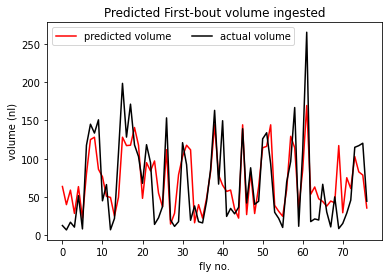

In [123]:
pred = knn.predict(X_tst)
act = y_tst
plt.title('Predicted First-bout volume ingested')
plt.plot(pred,label='predicted volume', color = 'red')
plt.plot(act,label='actual volume', color = 'k')
plt.legend(ncol=2)
plt.ylabel('volume (nl)')
plt.xlabel('fly no.')
plt.show()